# EE258 Project

Dataset : https://www.kaggle.com/crowww/a-large-scale-fish-dataset

Code References : https://www.tensorflow.org/tutorials/load_data/images

### Problem
The problem we hope to solve is creating an image classification model able to identify different types of fish or seafood at local supermarkets. The model will be able to identify at least 6 different classes of fish or seafood, with all other classes considered as "other".

In [1]:
pwd

'c:\\Users\\a1351\\ml\\EE258 Project'

In [2]:
# handle imports

import cv2
import os, glob
import matplotlib.pylab as plt
from os import listdir, makedirs
from os.path import isfile, join
import pandas as pd
import PIL
import numpy as np
from imageio import imread
import io
import pathlib
# from numba import jit, cuda

In [3]:
import tensorflow as tf
from tensorflow import keras
print("Tensorflow Version:",tf.__version__)
print("Keras Version:",keras.__version__)

Tensorflow Version: 2.7.0
Keras Version: 2.7.0


### Dataset

In [4]:
#path = 'C:/Users/a1351/ml/Fish_Dataset_6'

path = 'C:/Users/a1351/ml/Fish_Dataset'
data_dir = pathlib.Path(path)

image_count = len(list(data_dir.glob('**/*.png')))
print(image_count)

9000


The dataset is a total of 9000 445x590 pixel color images of fish with 1000 images per class. The dataset has been augmented per class with photo at different angles, rotated to generate 1000 data points per class. 

In [5]:
batch_size = 32
img_height = 445
img_width = 590

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height , img_width),
    batch_size = batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height , img_width),
    batch_size = batch_size
)

Found 9000 files belonging to 9 classes.
Using 7200 files for training.
Found 9000 files belonging to 9 classes.
Using 1800 files for validation.


In [6]:
class_names = train_ds.class_names
for name in class_names:
    print(name)


Black Sea Sprat
Gilt-Head Bream
Hourse Mackerel
Red Mullet
Red Sea Bream
Sea Bass
Shrimp
Striped Red Mullet
Trout


Found 9000 files belonging to 9 classes.
[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]


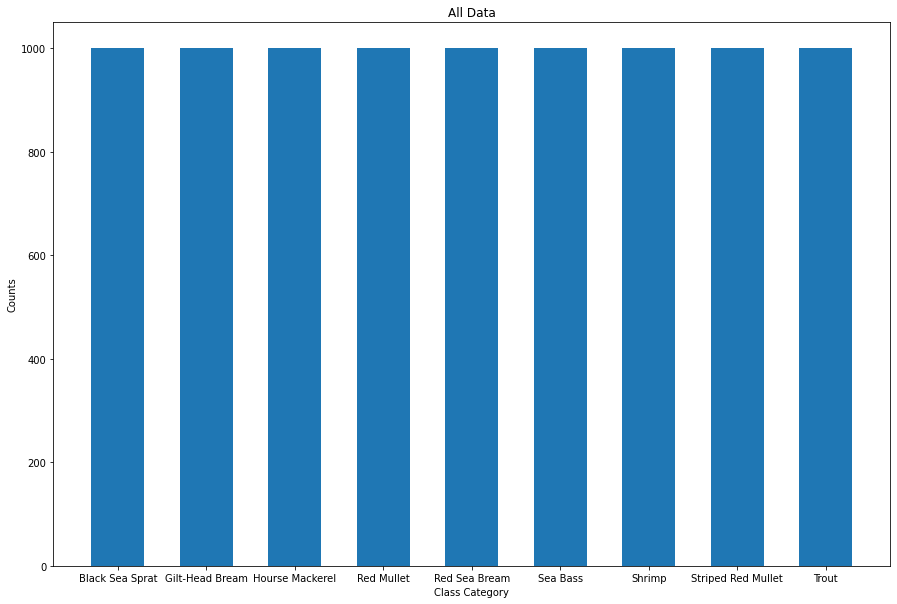

In [7]:
class_counts = np.zeros(len(class_names))
i = 0

all_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size = (img_height , img_width),
    seed=123
)

for all_img, all_labels in all_data:
    for cat in all_labels:
        class_counts[cat]+=1

print(class_counts)
plt.figure(figsize=(15,10))
distribution_data = dict(zip(class_names,class_counts))
plt.bar(list(distribution_data.keys()),distribution_data.values(),width =0.6)
plt.title('All Data')
plt.xlabel('Class Category')
plt.ylabel('Counts')
plt.show()


[802. 781. 794. 801. 798. 810. 810. 791. 813.]


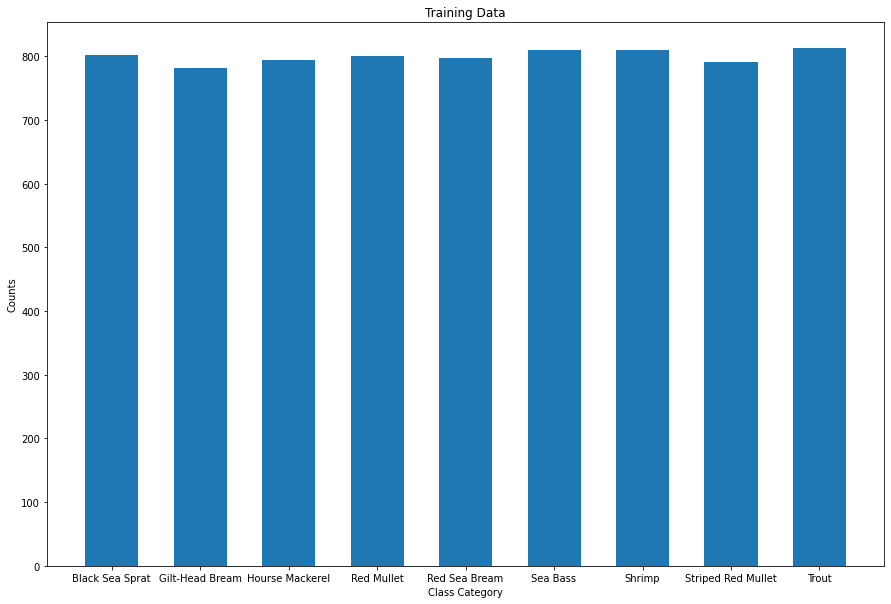

In [42]:
train_class_counts = np.zeros(len(class_names))
i = 0

for all_img, all_labels in train_ds:
    for cat in all_labels:
        train_class_counts[cat]+=1

print(train_class_counts)
plt.figure(figsize=(15,10))
train_distribution_data = dict(zip(class_names,train_class_counts))
plt.bar(list(train_distribution_data.keys()),train_distribution_data.values(),width =0.6)
plt.title('Training Data')
plt.xlabel('Class Category')
plt.ylabel('Counts')
plt.show()


[198. 219. 206. 199. 202. 190. 190. 209. 187.]


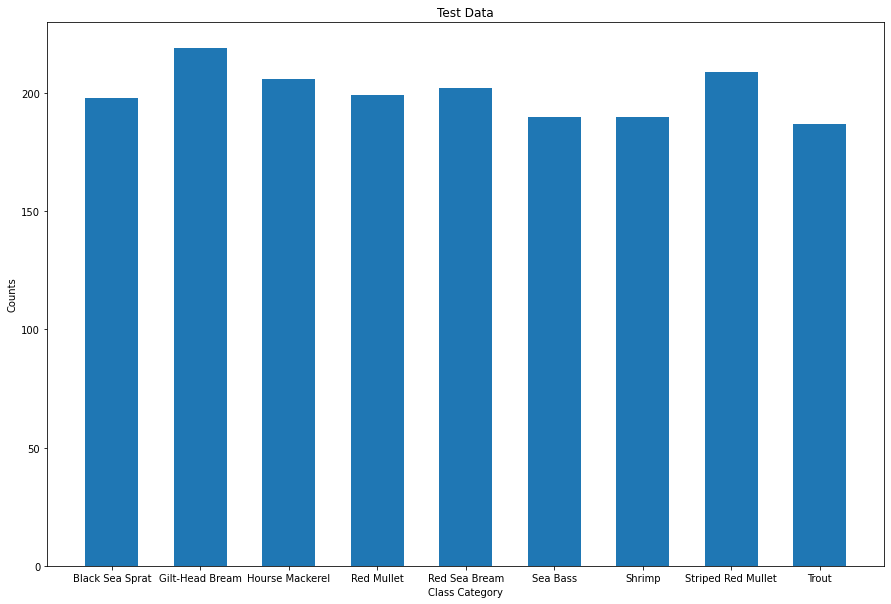

In [43]:
test_class_counts = np.zeros(len(class_names))
i = 0

for all_img, all_labels in test_ds:
    for cat in all_labels:
        test_class_counts[cat]+=1

print(test_class_counts)
plt.figure(figsize=(15,10))
test_distribution_data = dict(zip(class_names,test_class_counts))
plt.bar(list(test_distribution_data.keys()),test_distribution_data.values(),width =0.6)
plt.title('Test Data')
plt.xlabel('Class Category')
plt.ylabel('Counts')
plt.show()


#### Outliers

Originally, the dataset provided 2000 images per class. 1000 images were rgb photos of the fish at different angles, augmented by rotating the images around. The other 1000 images per class were black and white photos of the fish outline. These outline images were removed from the dataset resulting in the useful dataset of 9000 rbg images, with 1000 images per class.

### Visualization of Dataset

Below is visualization of each unique class of the dataset and respective class name. Rotated photos illustrate data augmentation done on original photos.

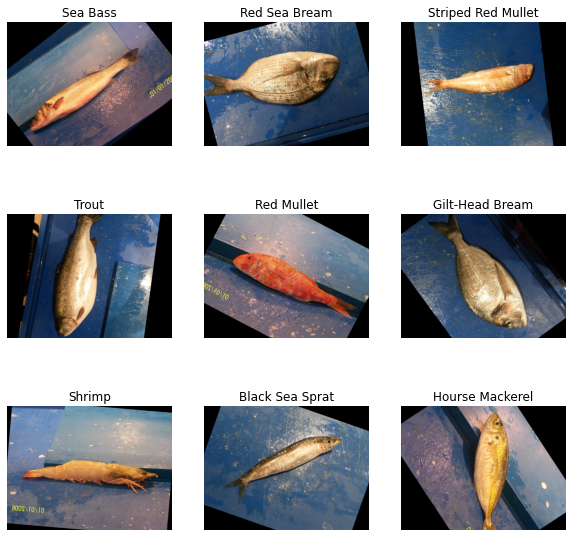

In [8]:
unique = []
i=0
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for item in range(len(labels)):
        if labels[item] in unique:
            continue
        else:
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[item].numpy().astype("uint8"))
            plt.title(class_names[labels[item]])
            plt.axis("off")

            i+=1
            unique.append(labels[item])
        
    break # run only once through a batch

In [9]:
## Reuse model from HW5

alt_model = keras.models.Sequential([
    # tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, 8, strides=2, kernel_regularizer='l2', activation="relu",input_shape=[445,590,3]),
    tf.keras.layers.MaxPool2D(2),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

## compile the basic model

sgd = keras.optimizers.SGD(learning_rate=0.001)
alt_model.compile(loss="sparse_categorical_crossentropy", optimizer=sgd,
              metrics=["accuracy"])



In [10]:

history = alt_model.fit(
                    train_ds,
                    batch_size=32, 
                    epochs=50,
                    validation_data =test_ds,
                    callbacks=[keras.callbacks.EarlyStopping(monitor="accuracy",min_delta=0.005,patience=2)])

Epoch 1/50
225/225 [==============================] - 27s 108ms/step - loss: 758.5516 - accuracy: 0.7633 - val_loss: 460.1338 - val_accuracy: 0.9356
Epoch 2/50
225/225 [==============================] - 24s 108ms/step - loss: 457.9917 - accuracy: 0.9685 - val_loss: 455.8834 - val_accuracy: 0.9783
Epoch 3/50
225/225 [==============================] - 24s 108ms/step - loss: 453.8181 - accuracy: 0.9846 - val_loss: 451.7812 - val_accuracy: 0.9844
Epoch 4/50
225/225 [==============================] - 24s 108ms/step - loss: 449.7245 - accuracy: 0.9928 - val_loss: 447.7114 - val_accuracy: 0.9889
Epoch 5/50
225/225 [==============================] - 24s 108ms/step - loss: 445.6830 - accuracy: 0.9956 - val_loss: 443.6955 - val_accuracy: 0.9883
Epoch 6/50
225/225 [==============================] - 24s 108ms/step - loss: 441.6784 - accuracy: 0.9993 - val_loss: 439.7092 - val_accuracy: 0.9906
Epoch 7/50
225/225 [==============================] - 24s 107ms/step - loss: 437.7175 - accuracy: 0.9994 -

In [11]:
alt_model.save('baseline_model_6class.h5')

In [12]:
two_dense_model = keras.models.Sequential([
    tf.keras.layers.Conv2D(64, 8, strides=2, activation="relu", input_shape=[445,590,3]),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

two_dense_model.compile(loss="sparse_categorical_crossentropy", optimizer=sgd,
                        metrics=["accuracy"])

In [13]:
history_two_dense_model = two_dense_model.fit(
                                        train_ds,
                                        batch_size=32,
                                        epochs=50,
                                        validation_data = test_ds,
                                        callbacks=[keras.callbacks.EarlyStopping(monitor="accuracy",min_delta=0.005,patience=2)])

Epoch 1/50
225/225 [==============================] - 23s 103ms/step - loss: nan - accuracy: 0.1114 - val_loss: nan - val_accuracy: 0.1100
Epoch 2/50
225/225 [==============================] - 23s 102ms/step - loss: nan - accuracy: 0.1114 - val_loss: nan - val_accuracy: 0.1100
Epoch 3/50
225/225 [==============================] - 23s 103ms/step - loss: nan - accuracy: 0.1114 - val_loss: nan - val_accuracy: 0.1100


In [14]:
dropout_model = keras.models.Sequential([
    # tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, 8, strides=2, activation="relu", input_shape=[445,590,3]),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

dropout_model.compile(loss="sparse_categorical_crossentropy", optimizer=sgd,
                    metrics=["accuracy"])


In [15]:
history_dropout = dropout_model.fit(
                                train_ds,
                                batch_size=32,
                                epochs=50,
                                validation_data = test_ds,
                                callbacks=[keras.callbacks.EarlyStopping(monitor="accuracy",min_delta=0.005,patience=2)])

Epoch 1/50
225/225 [==============================] - 25s 108ms/step - loss: 41.1453 - accuracy: 0.7099 - val_loss: 0.2800 - val_accuracy: 0.9244
Epoch 2/50
225/225 [==============================] - 24s 108ms/step - loss: 0.1877 - accuracy: 0.9500 - val_loss: 0.2170 - val_accuracy: 0.9389
Epoch 3/50
225/225 [==============================] - 24s 108ms/step - loss: 0.1058 - accuracy: 0.9699 - val_loss: 0.0824 - val_accuracy: 0.9728
Epoch 4/50
225/225 [==============================] - 25s 108ms/step - loss: 0.0688 - accuracy: 0.9760 - val_loss: 0.1050 - val_accuracy: 0.9689
Epoch 5/50
225/225 [==============================] - 25s 109ms/step - loss: 0.0584 - accuracy: 0.9812 - val_loss: 0.0484 - val_accuracy: 0.9839
Epoch 6/50
225/225 [==============================] - 25s 108ms/step - loss: 0.0695 - accuracy: 0.9878 - val_loss: 0.0554 - val_accuracy: 0.9861
Epoch 7/50
225/225 [==============================] - 25s 109ms/step - loss: 0.0317 - accuracy: 0.9929 - val_loss: 0.0386 - val_a

In [16]:
rescaling_model = keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, 8, strides=2, activation="relu", input_shape=[445,590,3]),
    tf.keras.layers.MaxPool2D(2),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

rescaling_model.compile(loss="sparse_categorical_crossentropy", optimizer=sgd,
                    metrics=["accuracy"])


In [17]:
history_rescaling = rescaling_model.fit(
                                train_ds,
                                batch_size=32,
                                epochs=50,
                                validation_data = test_ds,
                                callbacks=[keras.callbacks.EarlyStopping(monitor="accuracy",min_delta=0.005,patience=2)])

Epoch 1/50
225/225 [==============================] - 24s 105ms/step - loss: 1.7769 - accuracy: 0.3511 - val_loss: 1.4510 - val_accuracy: 0.4983
Epoch 2/50
225/225 [==============================] - 24s 105ms/step - loss: 1.2978 - accuracy: 0.5493 - val_loss: 1.1741 - val_accuracy: 0.5767
Epoch 3/50
225/225 [==============================] - 24s 105ms/step - loss: 1.0606 - accuracy: 0.6356 - val_loss: 0.9198 - val_accuracy: 0.7050
Epoch 4/50
225/225 [==============================] - 24s 105ms/step - loss: 0.8894 - accuracy: 0.6926 - val_loss: 0.9837 - val_accuracy: 0.6661
Epoch 5/50
225/225 [==============================] - 24s 105ms/step - loss: 0.7781 - accuracy: 0.7347 - val_loss: 0.6951 - val_accuracy: 0.7639
Epoch 6/50
225/225 [==============================] - 24s 105ms/step - loss: 0.6709 - accuracy: 0.7713 - val_loss: 0.7009 - val_accuracy: 0.7678
Epoch 7/50
225/225 [==============================] - 24s 105ms/step - loss: 0.5620 - accuracy: 0.8144 - val_loss: 0.5690 - val_ac

In [18]:
def create_model():
    alt_model = keras.models.Sequential([
    # tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, 8, strides=2, kernel_regularizer='l2', activation="relu", input_shape=[445,590,3]),
    tf.keras.layers.MaxPool2D(2),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

    ## compile the basic model

    sgd = keras.optimizers.SGD(learning_rate=0.001)
    alt_model.compile(loss="sparse_categorical_crossentropy", optimizer=sgd,
              metrics=["accuracy"])
    return alt_model

In [19]:
model1 = create_model()
model2 = create_model()
model3 = create_model()
model4 = create_model()
model5 = create_model()

In [20]:
hold1 = all_data.shard(num_shards=5, index=0)
hold2 = all_data.shard(num_shards=5, index=1)
hold3 = all_data.shard(num_shards=5, index=2)
hold4 = all_data.shard(num_shards=5, index=3)
hold5 = all_data.shard(num_shards=5, index=4)

train1 = hold2.concatenate(hold3)
train1 = train1.concatenate(hold4)
train1 = train1.concatenate(hold5)

train2 = hold3.concatenate(hold4)
train2 = train2.concatenate(hold5)
train2 = train2.concatenate(hold1)

train3 = hold4.concatenate(hold5)
train3 = train3.concatenate(hold1)
train3 = train3.concatenate(hold2)

train4 = hold5.concatenate(hold1)
train4 = train4.concatenate(hold2)
train4 = train4.concatenate(hold3)

train5 = hold1.concatenate(hold2)
train5 = train5.concatenate(hold3)
train5 = train5.concatenate(hold4)


In [21]:
history1 = model1.fit(
                    train1,
                    batch_size=32, 
                    epochs=50,
                    validation_data =hold1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor="accuracy",min_delta=0.005,patience=2)])

Epoch 1/50
225/225 [==============================] - 71s 317ms/step - loss: 1578.0421 - accuracy: 0.5330 - val_loss: 836.0503 - val_accuracy: 0.8865
Epoch 2/50
225/225 [==============================] - 74s 327ms/step - loss: 832.1365 - accuracy: 0.9241 - val_loss: 828.2693 - val_accuracy: 0.9556
Epoch 3/50
225/225 [==============================] - 75s 336ms/step - loss: 824.5635 - accuracy: 0.9562 - val_loss: 820.8193 - val_accuracy: 0.9644
Epoch 4/50
225/225 [==============================] - 76s 338ms/step - loss: 817.1544 - accuracy: 0.9610 - val_loss: 813.4642 - val_accuracy: 0.9638
Epoch 5/50
225/225 [==============================] - 76s 338ms/step - loss: 809.8239 - accuracy: 0.9691 - val_loss: 806.1756 - val_accuracy: 0.9622
Epoch 6/50
225/225 [==============================] - 77s 341ms/step - loss: 802.5538 - accuracy: 0.9692 - val_loss: 798.9317 - val_accuracy: 0.9709
Epoch 7/50
225/225 [==============================] - 75s 335ms/step - loss: 795.3522 - accuracy: 0.9720 

In [22]:
history2 = model2.fit(
                    train2,
                    batch_size=32, 
                    epochs=50,
                    validation_data =hold2,
                    callbacks=[keras.callbacks.EarlyStopping(monitor="accuracy",min_delta=0.005,patience=2)])

Epoch 1/50
225/225 [==============================] - 76s 336ms/step - loss: 1251.6705 - accuracy: 0.7299 - val_loss: 847.0751 - val_accuracy: 0.9350
Epoch 2/50
225/225 [==============================] - 77s 342ms/step - loss: 843.2203 - accuracy: 0.9531 - val_loss: 839.3860 - val_accuracy: 0.9744
Epoch 3/50
225/225 [==============================] - 78s 345ms/step - loss: 835.5969 - accuracy: 0.9789 - val_loss: 831.8302 - val_accuracy: 0.9822
Epoch 4/50
225/225 [==============================] - 78s 347ms/step - loss: 828.0953 - accuracy: 0.9858 - val_loss: 824.3483 - val_accuracy: 0.9900
Epoch 5/50
225/225 [==============================] - 78s 348ms/step - loss: 820.6551 - accuracy: 0.9915 - val_loss: 816.9450 - val_accuracy: 0.9917
Epoch 6/50
225/225 [==============================] - 78s 347ms/step - loss: 813.2847 - accuracy: 0.9960 - val_loss: 809.6068 - val_accuracy: 0.9994
Epoch 7/50
225/225 [==============================] - 78s 346ms/step - loss: 806.0009 - accuracy: 0.9968 

In [23]:
history3 = model3.fit(
                    train3,
                    batch_size=32, 
                    epochs=50,
                    validation_data =hold3,
                    callbacks=[keras.callbacks.EarlyStopping(monitor="accuracy",min_delta=0.005,patience=2)])

Epoch 1/50
226/226 [==============================] - 76s 336ms/step - loss: 718.3856 - accuracy: 0.5764 - val_loss: 335.2182 - val_accuracy: 0.8365
Epoch 2/50
226/226 [==============================] - 76s 335ms/step - loss: 333.4949 - accuracy: 0.9201 - val_loss: 331.8802 - val_accuracy: 0.9448
Epoch 3/50
226/226 [==============================] - 76s 335ms/step - loss: 330.3588 - accuracy: 0.9638 - val_loss: 328.8353 - val_accuracy: 0.9676
Epoch 4/50
226/226 [==============================] - 77s 341ms/step - loss: 327.3377 - accuracy: 0.9767 - val_loss: 325.9971 - val_accuracy: 0.9743
Epoch 5/50
226/226 [==============================] - 76s 336ms/step - loss: 324.3735 - accuracy: 0.9864 - val_loss: 322.8710 - val_accuracy: 0.9933
Epoch 6/50
226/226 [==============================] - 76s 337ms/step - loss: 321.4296 - accuracy: 0.9913 - val_loss: 319.9720 - val_accuracy: 0.9888
Epoch 7/50
226/226 [==============================] - 76s 335ms/step - loss: 318.5323 - accuracy: 0.9918 -

In [24]:
history4 = model4.fit(
                    train4,
                    batch_size=32, 
                    epochs=50,
                    validation_data =hold4,
                    callbacks=[keras.callbacks.EarlyStopping(monitor="accuracy",min_delta=0.005,patience=2)])

Epoch 1/50
226/226 [==============================] - 76s 335ms/step - loss: 968.3898 - accuracy: 0.7367 - val_loss: 764.6033 - val_accuracy: 0.9319
Epoch 2/50
226/226 [==============================] - 78s 343ms/step - loss: 761.0704 - accuracy: 0.9638 - val_loss: 757.5708 - val_accuracy: 0.9749
Epoch 3/50
226/226 [==============================] - 76s 334ms/step - loss: 754.1545 - accuracy: 0.9829 - val_loss: 750.7020 - val_accuracy: 0.9900
Epoch 4/50
226/226 [==============================] - 76s 336ms/step - loss: 747.3425 - accuracy: 0.9915 - val_loss: 743.9323 - val_accuracy: 0.9944
Epoch 5/50
226/226 [==============================] - 75s 333ms/step - loss: 740.6020 - accuracy: 0.9949 - val_loss: 737.2285 - val_accuracy: 0.9978
Epoch 6/50
226/226 [==============================] - 75s 331ms/step - loss: 734.0400 - accuracy: 0.9813 - val_loss: 730.7123 - val_accuracy: 0.9821


In [25]:
history5 = model5.fit(
                    train5,
                    batch_size=32, 
                    epochs=50,
                    validation_data =hold5,
                    callbacks=[keras.callbacks.EarlyStopping(monitor="accuracy",min_delta=0.005,patience=2)])

Epoch 1/50
226/226 [==============================] - 75s 331ms/step - loss: 291.5760 - accuracy: 0.7311 - val_loss: 148.0498 - val_accuracy: 0.9191
Epoch 2/50
226/226 [==============================] - 75s 331ms/step - loss: 147.3111 - accuracy: 0.9567 - val_loss: 146.5874 - val_accuracy: 0.9693
Epoch 3/50
226/226 [==============================] - 75s 332ms/step - loss: 145.9890 - accuracy: 0.9637 - val_loss: 145.3021 - val_accuracy: 0.9749
Epoch 4/50
226/226 [==============================] - 75s 332ms/step - loss: 144.6360 - accuracy: 0.9753 - val_loss: 143.9198 - val_accuracy: 0.9927
Epoch 5/50
226/226 [==============================] - 75s 334ms/step - loss: 143.2796 - accuracy: 0.9901 - val_loss: 142.6192 - val_accuracy: 0.9927
Epoch 6/50
226/226 [==============================] - 75s 334ms/step - loss: 142.0106 - accuracy: 0.9867 - val_loss: 141.3353 - val_accuracy: 0.9939
Epoch 7/50
226/226 [==============================] - 77s 342ms/step - loss: 140.7068 - accuracy: 0.9943 -

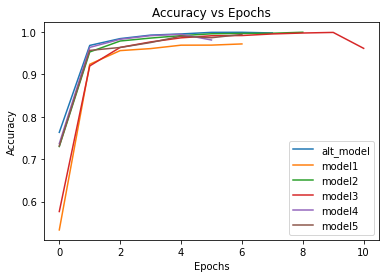

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history1.history['accuracy'])
plt.plot(history2.history['accuracy'])
plt.plot(history3.history['accuracy'])
plt.plot(history4.history['accuracy'])
plt.plot(history5.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend(['alt_model','model1','model2','model3','model4','model5'])

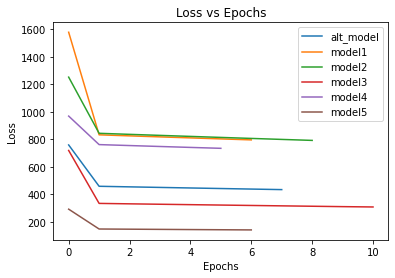

In [27]:
plt.plot(history.history['loss'])
plt.plot(history1.history['loss'])
plt.plot(history2.history['loss'])
plt.plot(history3.history['loss'])
plt.plot(history4.history['loss'])
plt.plot(history5.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend(['alt_model','model1','model2','model3','model4','model5'])

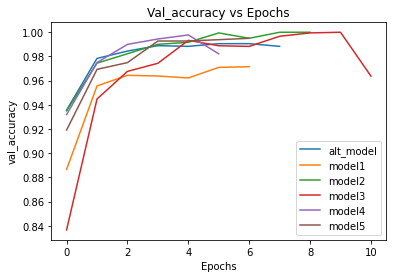

In [28]:
plt.plot(history.history['val_accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('val_accuracy')
plt.title('Val_accuracy vs Epochs')
plt.legend(['alt_model','model1','model2','model3','model4','model5'])

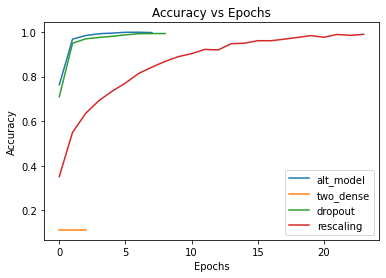

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history_two_dense_model.history['accuracy'])
plt.plot(history_dropout.history['accuracy'])
plt.plot(history_rescaling.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend(['alt_model','two_dense','dropout','rescaling'])

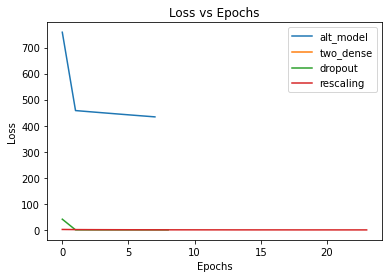

In [30]:
plt.plot(history.history['loss'])
plt.plot(history_two_dense_model.history['loss'])
plt.plot(history_dropout.history['loss'])
plt.plot(history_rescaling.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend(['alt_model','two_dense','dropout','rescaling'])

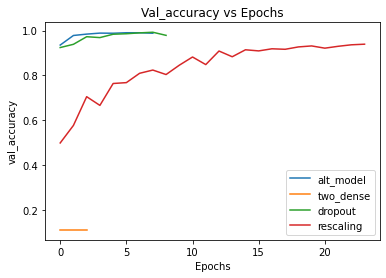

In [31]:
plt.plot(history.history['val_accuracy'])
plt.plot(history_two_dense_model.history['val_accuracy'])
plt.plot(history_dropout.history['val_accuracy'])
plt.plot(history_rescaling.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('val_accuracy')
plt.title('Val_accuracy vs Epochs')
plt.legend(['alt_model','two_dense','dropout','rescaling'])

In [44]:
#Plot the confusion matrix.
def cm_plot(cm, classes, title):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [45]:
test_labels = np.array([])
for images, labels in test_ds:
    for item in range(len(labels)):
        test_labels = np.append(test_labels,labels[item])

tf.Tensor(
[[22 32 18 19 19 16 22 21 29]
 [28 24 19 20 34 19 25 26 24]
 [24 26 23 27 25 23 19 17 22]
 [21 19 22 27 11 30 25 28 16]
 [25 24 25 20 23 23 25 16 21]
 [19 22 26 19 25 19 13 29 18]
 [16 35 26 13 25 20 22 16 17]
 [21 20 31 31 16 22 26 32 10]
 [17 21 16 19 26 18 19 21 30]], shape=(9, 9), dtype=int32)


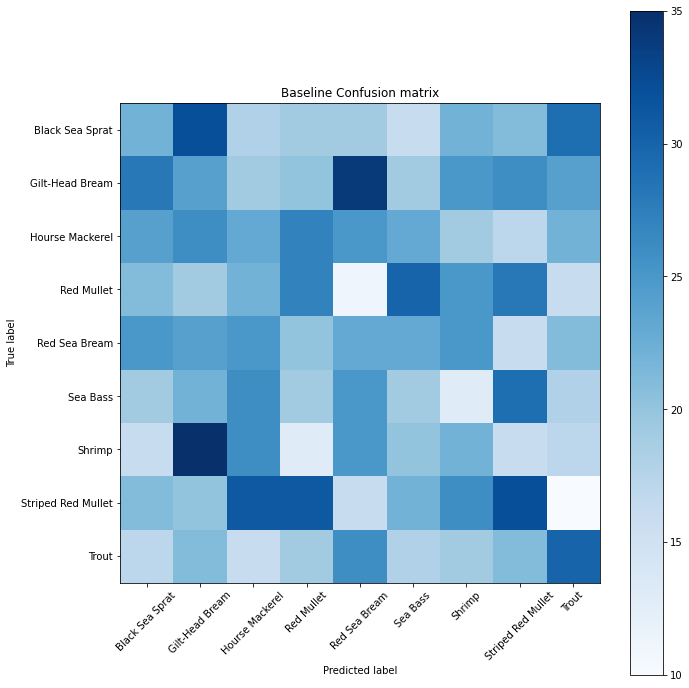

In [46]:
alt_y_pred_full = alt_model.predict(test_ds, batch_size=32)
alt_y_pred = np.argmax(alt_y_pred_full, axis=1)

alt_cm = tf.math.confusion_matrix(test_labels, alt_y_pred, num_classes=len(class_names))
print(alt_cm)
cm_plot(alt_cm, class_names, title='Baseline Confusion matrix')

tf.Tensor(
[[198   0   0   0   0   0   0   0   0]
 [219   0   0   0   0   0   0   0   0]
 [206   0   0   0   0   0   0   0   0]
 [199   0   0   0   0   0   0   0   0]
 [202   0   0   0   0   0   0   0   0]
 [190   0   0   0   0   0   0   0   0]
 [190   0   0   0   0   0   0   0   0]
 [209   0   0   0   0   0   0   0   0]
 [187   0   0   0   0   0   0   0   0]], shape=(9, 9), dtype=int32)


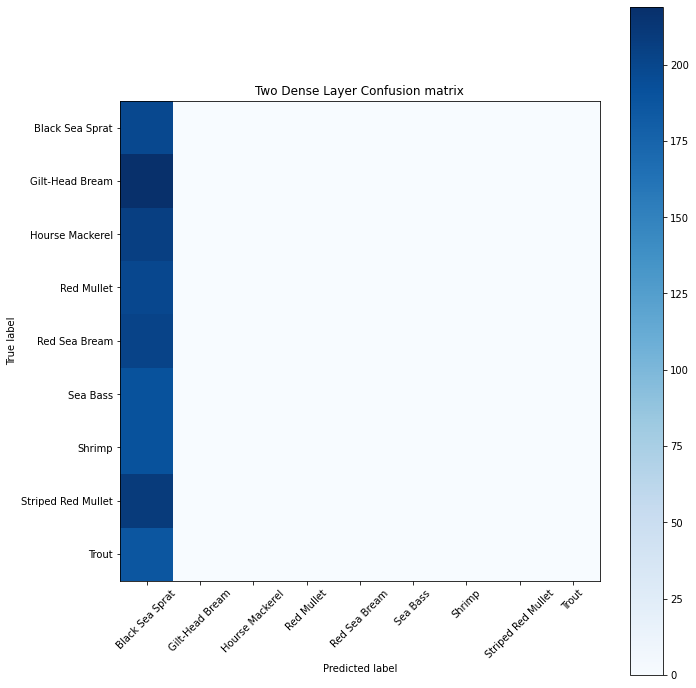

In [47]:
two_dense_y_pred_full = two_dense_model.predict(test_ds, batch_size=32)
two_dense_y_pred = np.argmax(two_dense_y_pred_full, axis=1)

two_dense_cm = tf.math.confusion_matrix(test_labels, two_dense_y_pred, num_classes=len(class_names))
print(two_dense_cm)
cm_plot(two_dense_cm, class_names, title='Two Dense Layer Confusion matrix')

tf.Tensor(
[[27 25 20 15 24 22 19 23 23]
 [20 24 24 24 22 17 30 30 28]
 [28 19 26 21 27 26 17 23 19]
 [21 17 16 24 21 23 27 26 24]
 [30 32 20 19 19 22 17 21 22]
 [21 27 28 20 15 20 22 17 20]
 [26 26 28 26 18 12 19 17 18]
 [20 25 23 27 25 27 22 23 17]
 [21 29 23 19 19 12 21 26 17]], shape=(9, 9), dtype=int32)


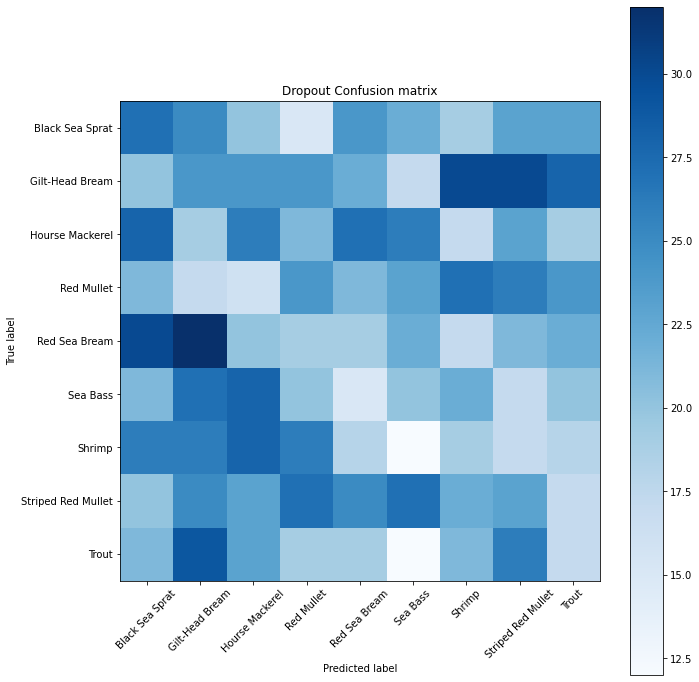

In [48]:
dropout_y_pred_full = dropout_model.predict(test_ds, batch_size=32)
dropout_y_pred = np.argmax(dropout_y_pred_full, axis=1)

dropout_cm = tf.math.confusion_matrix(test_labels, dropout_y_pred, num_classes=len(class_names))
print(dropout_cm)
cm_plot(dropout_cm, class_names, title='Dropout Confusion matrix')

tf.Tensor(
[[24 22 24 28 18 15 26 27 14]
 [23 27 24 15 32 31 23 19 25]
 [31 21 18 25 18 22 20 25 26]
 [31 26 14 19 29 18 22 18 22]
 [19 28 31 19 26 18 17 19 25]
 [25 26 19 18 18 17 24 28 15]
 [15 24 22 19 22 20 21 19 28]
 [27 24 23 33 20 20 22 28 12]
 [24 24 21 21 18 20 14 20 25]], shape=(9, 9), dtype=int32)


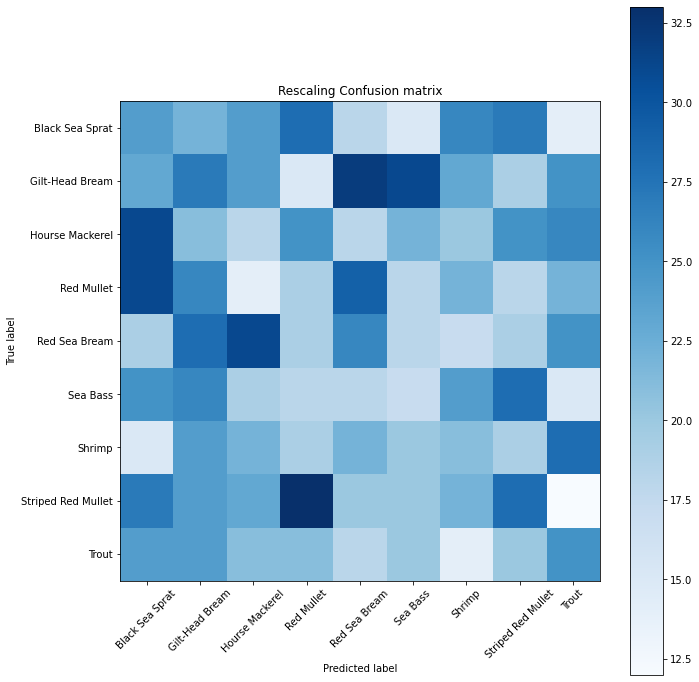

In [49]:
rescaling_y_pred_full = rescaling_model.predict(test_ds, batch_size=32)
rescaling_y_pred = np.argmax(rescaling_y_pred_full, axis=1)

rescaling_cm = tf.math.confusion_matrix(test_labels, rescaling_y_pred, num_classes=len(class_names))
print(rescaling_cm)
cm_plot(rescaling_cm, class_names, title='Rescaling Confusion matrix')